In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)
import matplotlib.pyplot as plt
from functools import reduce

# Obtencion data

In [2]:
### API
binance_api_key = ''    #Enter your own API-key here
binance_api_secret = '' #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "15m" : 15, "1h": 60, "1d": 1440}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2018', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

# Gets all data for specific symbol. Gets only new data if previous already available
def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2018', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

Download data for BTC, ETH and LTC

In [3]:
tickers = ["BTCUSDT", "ETHUSDT", "LTCUSDT"]
for ticker in tickers:
    data=get_all_binance(ticker,"1d", save = True)

All caught up..!
All caught up..!
All caught up..!


In [4]:
data_btc=pd.read_csv("BTCUSDT-1d-data.csv")
data_eth=pd.read_csv("ETHUSDT-1d-data.csv")
data_ltc=pd.read_csv("LTCUSDT-1d-data.csv")

In [5]:
#data_mes=data.loc['2021-01-03 12:00:00':'2021-01-5 12:00:00']
#data_mes=data
#data_mes=data_mes.astype(float)

# Calculations

Only need closing price and data. Drop all other cols

In [6]:
data_btc.drop(data_btc.columns.difference(['timestamp','close']), 1, inplace=True)
data_eth.drop(data_eth.columns.difference(['timestamp','close']), 1, inplace=True)
data_ltc.drop(data_ltc.columns.difference(['timestamp','close']), 1, inplace=True)

Set timestamp as index

In [7]:
data_btc

,timestamp,close
0,2018-01-01,13380.00
1,2018-01-02,14675.11
2,2018-01-03,14919.51
3,2018-01-04,15059.54
4,2018-01-05,16960.39
...,...,...
1305,2021-07-29,40016.48
1306,2021-07-30,42206.37
1307,2021-07-31,41461.83
1308,2021-08-01,41750.06


In [8]:
data_btc.set_index('timestamp', inplace=True)
data_eth.set_index('timestamp', inplace=True)
data_ltc.set_index('timestamp', inplace=True)

Join them on index

In [9]:
dfs = [data_btc, data_eth, data_ltc]

In [10]:
df_merged = pd.concat(dfs, join='outer', axis=1).fillna('void')
df_merged.columns = ['btc_close', 'eth_close', 'ltc_close']
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1310 entries, 2018-01-01 to 2021-08-01 00:00:00
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   btc_close  1310 non-null   float64
 1   eth_close  1310 non-null   float64
 2   ltc_close  1310 non-null   float64
dtypes: float64(3)
memory usage: 40.9+ KB


In [11]:
df_merged

,btc_close,eth_close,ltc_close
timestamp,,,
2018-01-01,13380.00,754.99,222.61
2018-01-02,14675.11,855.28,247.33
2018-01-03,14919.51,934.03,238.77
2018-01-04,15059.54,940.00,233.00
2018-01-05,16960.39,959.30,240.54
...,...,...,...
2021-07-29,40016.48,2382.92,141.44
2021-07-30,42206.37,2461.81,145.51
2021-07-31,41461.83,2531.05,144.37


In [12]:
returns = np.log(df_merged) / df_merged.shift(1)
returns

,btc_close,eth_close,ltc_close
timestamp,,,
2018-01-01,NaN,NaN,NaN
2018-01-02,0.000717,0.008942,0.024755
2018-01-03,0.000655,0.007997,0.022138
2018-01-04,0.000645,0.007329,0.022830
2018-01-05,0.000647,0.007304,0.023532
...,...,...,...
2021-07-29,0.000265,0.003380,0.035265
2021-07-30,0.000266,0.003277,0.035211
2021-07-31,0.000252,0.003183,0.034172


In [13]:
print('Ann returns')
print((returns[df_merged.columns].mean() * 365).to_string())

Ann returns
btc_close     0.380207
eth_close     7.369561
ltc_close    22.065251


In [14]:
print('std dev')
print((returns[df_merged.columns].std() * 365).to_string())

std dev
btc_close    0.195799
eth_close    4.275417
ltc_close    9.162115


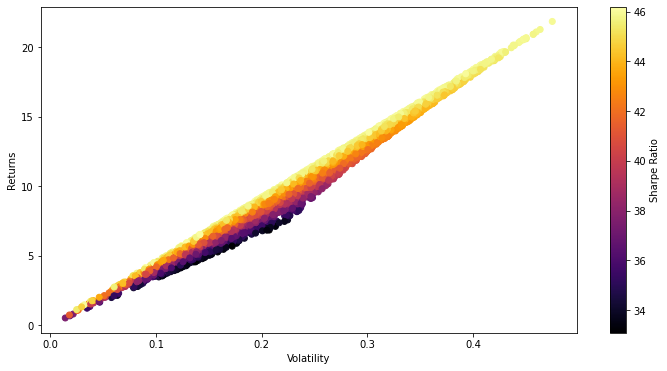

In [51]:
rf = 0.0016 # Assume 0.16% risk free rate
num_portfolios = 5000

#variables to store the results of monte carlo simulation
portfolio_returns = []
portfolio_risk = []
portfolio_sharpe_ratios = []
portfolio_weights = []


#loop with num of interations equal to num of portfolios
for i in range(num_portfolios):
    #generate random weights
    weights = np.random.random_sample((len(tickers)))
    weights = weights / np.sum(weights) #normalize weights
    
    #store weights
    portfolio_weights.append(weights)
    
    #calculate annualized return based on asset allocation
    annualized_return = np.sum(pd.concat([pd.Series(returns[['btc_close']].mean() * weights[0] * 365),
                                         pd.Series(returns[['eth_close']].mean() * weights[1] * 365),
                                         pd.Series(returns[['ltc_close']].mean() * weights[2] * 365)]))
    
    portfolio_returns.append(annualized_return) #save returns for each specific portfolio
    
    #calculate variance/risk
    matrix_covariance = returns.cov()
    tickers = ['btc_close', 'eth_close', 'ltc_close']
    for ticker in tickers:
        matrix_covariance[ticker] = matrix_covariance[ticker] * 365
    
    portfolio_variance = np.dot(weights.T, np.dot(matrix_covariance, weights))
    portfolio_std = np.sqrt(portfolio_variance)
    portfolio_risk.append(portfolio_std)
    
    #calculate sharpe ratio
    sharpe_ratio = ((annualized_return - rf) / portfolio_std)
    portfolio_sharpe_ratios.append(sharpe_ratio)
    
portfolio_returns = np.array(portfolio_returns)
portfolio_risk = np.array(portfolio_risk)
portfolio_sharpe_ratios = np.array(portfolio_sharpe_ratios)

#Plot the risk vs return of all portfolios to visualize the Efficient Frontier
plt.figure(figsize = (12,6))
plt.scatter(portfolio_risk, portfolio_returns, c = portfolio_returns / portfolio_risk, cmap ='inferno')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar(label = 'Sharpe Ratio')

#Save portfolio information into dataframe
portfolio_metrics = [portfolio_returns, portfolio_risk, portfolio_sharpe_ratios, portfolio_weights]
df_portfolios = pd.DataFrame(portfolio_metrics)
df_portfolios = df_portfolios.T
df_portfolios.columns = ['Returns', 'Risk', 'Sharpe Ratio', 'Weights']

#change types to float64
df_portfolios['Returns'] = df_portfolios['Returns'].astype('float64')
df_portfolios['Risk'] = df_portfolios['Risk'].astype('float64')
df_portfolios['Sharpe Ratio'] = df_portfolios['Sharpe Ratio'].astype('float64')

#Find the portfolio with the highest Sharpe Ratio
highest_sharpe_ratio = df_portfolios.loc[df_portfolios['Sharpe Ratio'].idxmax()]

#Find the portfolio with the highest returns
max_returns = df_portfolios.loc[df_portfolios['Returns'].idxmax()]

#Find the portfolio with the lowest risk
min_risk = df_portfolios.loc[df_portfolios['Risk'].idxmin()]

In [52]:
highest_sharpe_ratio

Returns                                                   6.52778
Risk                                                     0.141291
Sharpe Ratio                                              46.1895
Weights         [0.7148699961345147, 0.002414628953445939, 0.2...
Name: 4446, dtype: object

In [53]:
max_returns

Returns                                                   21.8422
Risk                                                     0.474907
Sharpe Ratio                                              45.9891
Weights         [0.005835040988439793, 0.0065691793153177256, ...
Name: 1621, dtype: object

In [54]:
min_risk

Returns                                                  0.537954
Risk                                                     0.014331
Sharpe Ratio                                              37.4262
Weights         [0.978714582030585, 0.02067461406865129, 0.000...
Name: 1427, dtype: object